In [ ]:
import adabmDCA
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot 
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
from tqdm import tqdm
import autoencoder
from sklearn.mixture import GaussianMixture
import GM
import utils
from scipy.stats import pearsonr
import my_scripts
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from adabmDCA.fasta import get_tokens

In [31]:
# load Pott's model

model_path = "/home/fefe/Téléchargements/bmDCA_params(1).dat"
params = adabmDCA.io.load_params(model_path, device="cpu", tokens=get_tokens("protein"))
params_profile = adabmDCA.io.load_params_oldformat("/home/fefe/Documents/Stage/code/bmDCA_params.dat", device="cpu")

# load Autoencoder

SEED = 11
MSA_length = 202
AA_latent = 50
latent_dim = 100

AE_v1 = autoencoder.Autoencoder_v1(taille=MSA_length, AA_latent=AA_latent, latent_dim=latent_dim, dropout_rate=0.3)

AE_v1.load_state_dict(torch.load('modele/ae_v1.pth'))

with open("encoder.pkl", "rb") as f:
    encoder = pickle.load(f) 

# load Gaussian Mixture 

gm = GaussianMixture()
gm.weights_ = np.load("GM/weights.npy")
gm.means_ = np.load("GM/means.npy")
gm.covariances_ = np.load("GM/covariances.npy")
gm.precisions_cholesky_ = np.load("GM/precisions_cholesky.npy")

W = np.load("GM/weights.npy")
M = np.load("GM/means.npy")
S = np.load("GM/covariances.npy")
 

gm2 = GM.GaussianMixture(W, M, S)

sampler = get_sampler("gibbs")

In [8]:
# Deep mutation scanning

wt = "--NGEYWDYNGNQRFPLTSTFKTIACAKLLYDAEQGKVNPNSTVEIKKADLVTYSPVIEKQVGQAITLDDACFATMTTSDNTAANIILSAVGPKGVTDFLRQIGDKETRLDRIEPDLNGKLGDLRDTTTPKAIASTLNKFLFGSALSEMKLESWMVNQVTGNLLRSVLPAGWNIADRSGAGFGARSITAVVWSHQAPIIVS-"
seq = [my_scripts.AA_to_indice[aa] for aa in wt]
dms = utils.DMS(seq)
dms_onehot = np.zeros((dms.shape[0], dms.shape[1] * 21))

for i, seq in enumerate(dms) : 

    dms_onehot[i] = np.array([1 if i == aa else 0 for aa in seq for i in range(21)])

latent_dms = AE_v1.encoder(torch.tensor(dms_onehot, dtype=torch.float32)).detach().numpy()

In [9]:
# load trajectory 


# Training data
X,Y,labels = my_scripts.generation_dataset(18000, SEED)
latent_X = AE_v1.encoder(torch.Tensor(X)).detach().numpy()
print("Training data loaded")

# Potts model generation
rand_init = one_hot(torch.randint(0, 21, size=(100, 202)), num_classes=21)
gen = sampler(rand_init, params=params, nsweeps=1000).numpy()
latent_gen = AE_v1.encoder(torch.Tensor(gen)).detach().numpy()
print("Potts model generation done")

# Potts model profile generation
rand_init = one_hot(torch.randint(0, 21, size=(100, 202)), num_classes=21)
gen_profile = sampler(rand_init, params=params_profile, nsweeps=1000).numpy()
latent_gen_profile = AE_v1.encoder(torch.Tensor(gen_profile)).detach().numpy()
print("Potts model generation done")

# Autoencoder generation
path = "/home/fefe/Documents/Stage/code/pl/Generated/gen.faa"
X_traj = my_scripts.generation_traj(50_000, path_to_traj=path)
latent_X_AE = AE_v1.encoder(torch.Tensor(X_traj)).detach().numpy()
print("Autoencoder generation done")

# Other family 
path = "/home/fefe/Documents/Stage/code/leonardodibari/leonardodibari-Gen.jl-bbc6b32/data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
X_dnd = my_scripts.generation_traj(50_000, path_to_traj=path)
padd = np.zeros((X_dnd.shape[0], X_traj.shape[1] - X_dnd.shape[1]))
for i in range(1, 127) : 

    padd[:, i*20] = np.ones(X_dnd.shape[0])

X_dnd = np.concatenate((X_dnd, padd), axis=1)[:8000,:]
latent_dnb = AE_v1.encoder(torch.Tensor(X_dnd)).detach().numpy()
print("DNB generation done")


Training data loaded
Potts model generation done
Potts model generation done
Autoencoder generation done
DNB generation done


In [ ]:
# Compute Energy

E_train = np.zeros(X.shape[0])
x = torch.from_numpy(X).reshape(X.shape[0], 202, 21).float()
for i in tqdm(range(X.shape[0])) :

    E_train[i] =  adabmDCA.statmech.compute_energy(x[i].reshape(1, 202, 21), params) 

E_potts = np.zeros(gen.shape[0])
X_potts = torch.from_numpy(gen).reshape(gen.shape[0], 202, 21).float()
for i in tqdm(range(gen.shape[0])) :

    E_potts[i] =  adabmDCA.statmech.compute_energy(X_potts[i].reshape(1, 202, 21), params)

E_potts_prof = np.zeros(gen_profile.shape[0])
X_potts_prof = torch.from_numpy(gen_profile).reshape(gen_profile.shape[0], 202, 21).float()
for i in tqdm(range(gen_profile.shape[0])) :

    E_potts_prof[i] =  adabmDCA.statmech.compute_energy(X_potts_prof[i].reshape(1, 202, 21), params)

E_AE = np.zeros(X_traj.shape[0])
X_AE = torch.from_numpy(X_traj).reshape(X_traj.shape[0], 202, 21).float()
for i in tqdm(range(X_traj.shape[0])) :

    E_AE[i] =  adabmDCA.statmech.compute_energy(X_AE[i].reshape(1, 202, 21), params)

E_DMS = np.zeros(dms_onehot.shape[0])
X_DMS = torch.from_numpy(dms_onehot).reshape(dms_onehot.shape[0], 202, 21).float()
for i in tqdm(range(dms_onehot.shape[0])) :

    E_DMS[i] =  adabmDCA.statmech.compute_energy(X_DMS[i].reshape(1, 202, 21), params)  

E_DNB = np.zeros(X_dnd.shape[0])
X_DNB = torch.from_numpy(X_dnd).reshape(X_dnd.shape[0], 202, 21).float()
for i in tqdm(range(X_dnd.shape[0])) :

    E_DNB[i] =  adabmDCA.statmech.compute_energy(X_DNB[i].reshape(1, 202, 21), params)  

  0%|          | 0/18000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:14<00:00, 133.99it/s]


NameError: name 'dms_onehot' is not defined

In [9]:
# Get probability 

P_train = np.zeros(X.shape[0])
for i in tqdm(range(X.shape[0])) :

    P_train[i] = np.log(gm2.transform2(latent_X[i]))

P_potts = np.zeros(gen.shape[0])
for i in tqdm(range(gen.shape[0])) :

    P_potts[i] = np.log(gm2.transform2(latent_gen[i]))

P_potts_prof = np.zeros(gen_profile.shape[0])
for i in tqdm(range(gen_profile.shape[0])) :

    P_potts_prof[i] = np.log(gm2.transform2(latent_gen_profile[i]))

P_AE = np.zeros(X_traj.shape[0])
for i in tqdm(range(X_traj.shape[0])) :

    P_AE[i] = np.log(gm2.transform2(latent_X_AE[i]))

P_dms = np.zeros(dms_onehot.shape[0])
for i in tqdm(range(dms_onehot.shape[0])) :

    P_dms[i] = np.log(gm2.transform2(latent_dms[i]))

P_DNB = np.zeros(X_dnd.shape[0])
for i in tqdm(range(X_dnd.shape[0])) :

    P_DNB[i] = np.log(gm2.transform2(latent_dnb[i]))


100%|██████████| 8000/8000 [00:03<00:00, 2180.57it/s]


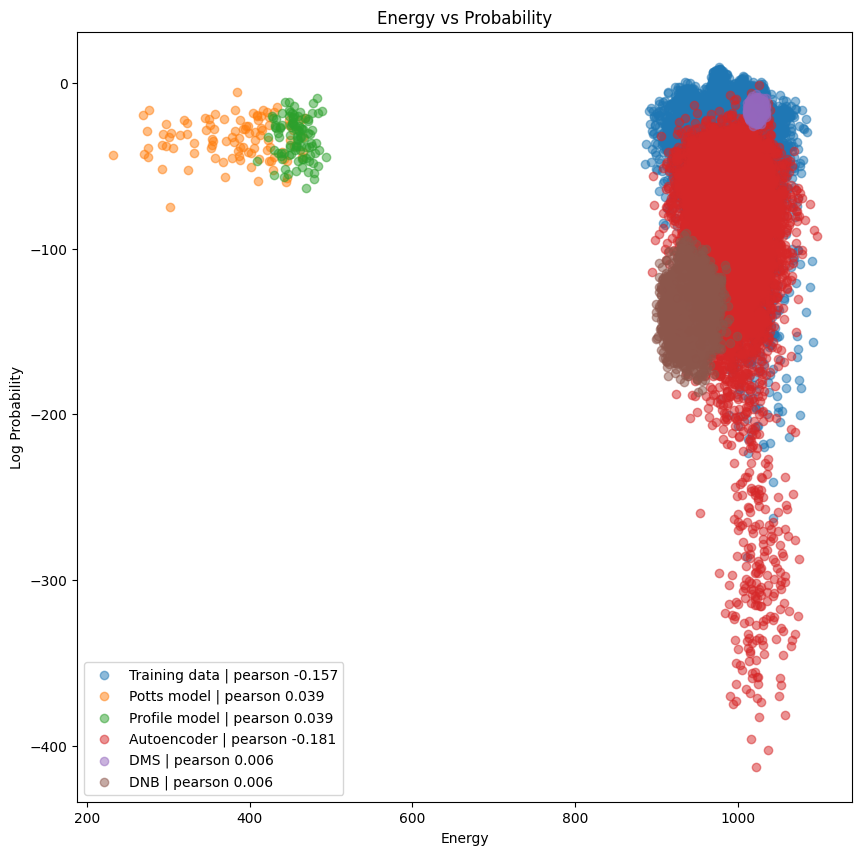

In [14]:

plt.figure(figsize=(10,10))

plt.scatter(E_train, P_train, label=f"Training data | pearson {pearsonr(E_train, P_train)[0]:.3f}", alpha=0.5)
plt.scatter(E_potts, P_potts, label=f"Potts model | pearson {pearsonr(E_potts, P_potts)[0]:.3f}", alpha=0.5)
plt.scatter(E_potts_prof, P_potts_prof, label=f"Profile model | pearson {pearsonr(E_potts, P_potts)[0]:.3f}", alpha=0.5)
plt.scatter(E_AE, P_AE, label=f"Autoencoder | pearson {pearsonr(E_AE, P_AE)[0]:.3f}", alpha=0.5)
plt.scatter(E_DMS, P_dms, label=f"DMS | pearson {pearsonr(E_DMS, P_dms)[0]:.3f}", alpha=0.5)
plt.scatter(E_DNB, P_DNB, label=f"DNB | pearson {pearsonr(E_DMS, P_dms)[0]:.3f}", alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Log Probability")
plt.title("Energy vs Probability")
#plt.yscale("log")
plt.legend()
plt.show()

